In [1]:
import os
import re
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
data_directory = os.path.join(os.getcwd(), 'data')
training_files = []

'''
Iterates through the current directory to fetch all training files i.e training.de, training.en, training.es
Stores the absolute path of these files in the training_files list
'''
[training_files.append(data_directory + '/' + training_file) for training_file in os.listdir(data_directory) if training_file.startswith('training')]
print(training_files)

['/afs/inf.ed.ac.uk/user/s24/s2446690/Desktop/anlp/assignment1/data/training.es', '/afs/inf.ed.ac.uk/user/s24/s2446690/Desktop/anlp/assignment1/data/training.en', '/afs/inf.ed.ac.uk/user/s24/s2446690/Desktop/anlp/assignment1/data/training.de', '/afs/inf.ed.ac.uk/user/s24/s2446690/Desktop/anlp/assignment1/data/training_en_words_with_ng.csv']


In [3]:
 vocabulary = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
               'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 
               '0', '.', ' ']

In [4]:
# Question 1
def preprocess_line(line):
    '''
    The regex below defines a character set consisting of only alphabets, digits, spaces, full-stops and sentence markers
    1. Remove all unwanted characters that are not part of this character set
    2. Additionally replace all digits with 0
    3. Finally, add beginning and end of sentence markers before returning the line
    '''
    return '##' + re.sub(r'[^a-z\d\s.]+', '', re.sub(r'\d', '0', line.lower())) + '#'

In [5]:
# Question 3 a.
def generate_trigrams_from_vocabulary():
    '''
    Generates all possible combinations of trigrams from the defined vocabulary
    '''
    # We use the '#' character to symbolise both, the beginning i.e., <s> and end i.e., </s> of a sentence
    
    # Generate trigrams with the beginning-of-sentence marker i.e., of type <s><s>a
    set_of_all_possible_trigrams = ['##' + character for character in vocabulary]
    
    # Generate all trigrams that are read from the second sentence marker onwards i.e., of type <s>ab
    set_of_all_possible_trigrams.extend(['#' + character_one + character_two for character_one in vocabulary for character_two in vocabulary])
    
    # Generate all trigrams with the end-of-sentence marker i.e. of type ab</s>
    set_of_all_possible_trigrams.extend([character_n_minus_one + character_n_minus_two + '#' for character_n_minus_one in vocabulary for character_n_minus_two in vocabulary])
    
    # Generate all trigrams that occur within the sentence (i.e., everything in between the sentence markers)
    set_of_all_possible_trigrams.extend([character_one + character_two + character_three for character_one in vocabulary for character_two in vocabulary for character_three in vocabulary])
    
    # Return the set of all possible trigrams generated from the given vocabulary
    return set_of_all_possible_trigrams

In [6]:
# Question 3 b.
def model_trigrams_from_training_data(training_file):
    '''
    Generates a trigram character language model by estimating probabilties from the training data
    '''
    set_of_all_possible_trigrams = generate_trigrams_from_vocabulary()
    distribution_over_next_characters = defaultdict()
    
    # Contruct a map with unique bigram histories as keys and a list of all-possible-next-characters as their value-pair (defined as dict within dict model)
    for trigram in set_of_all_possible_trigrams:
        bigram = trigram[0:2]
        next_character = trigram[2]
        if bigram not in distribution_over_next_characters:
            distribution_over_next_characters[bigram] = defaultdict()
        if next_character not in distribution_over_next_characters[bigram]:
            distribution_over_next_characters[bigram][next_character] = 0
            
    # Read the training file and compute all trigram counts
    with open(training_file, 'r') as file:
        for line in file:
            # Preprocess the data line-wise
            preprocessed_line = preprocess_line(line.rstrip())
            # Define a dictionary to hold all the trigram counts in the training data
            for index in range(len(preprocessed_line) - 2):
                trigram = preprocessed_line[index: index + 3]
                bigram_history = trigram[0:2]
                next_character = trigram[2]
                # Prevents inclusion of invalid trigrams like #{char}# and {char}#{char}
                if bigram_history in distribution_over_next_characters and next_character in distribution_over_next_characters[bigram_history]:
                    distribution_over_next_characters[bigram_history][next_character] += 1
    file.close()
    
    total_num_bigrams = 0
    vocabulary_size = len(vocabulary)
    smoothing_constant_alpha = 0.7516756756756757
    # Extract the language suffix from the training file (i.e. en, es or de)
    # Create a new file to write out the trained model probabilities for each of the above training files
    trigram_model = data_directory + '/' + '{}_trained_trigram_model'.format(training_file[-2:])
    
    # Compute the probability distributions over the trigrams in the training data and write these out to a file
    with open(trigram_model, 'w+') as file:
        for bigram_history in distribution_over_next_characters:
            # Calculate the total number of trigram instances with the same bigram history
            total_num_bigrams = sum(distribution_over_next_characters[bigram_history].values())
            for next_character in distribution_over_next_characters[bigram_history]:
                # For each bigram in the vocabulary, perform add alpha smoothing over the next possible trigram character
                distribution_over_next_characters[bigram_history][next_character] += smoothing_constant_alpha
                distribution_over_next_characters[bigram_history][next_character] /= (total_num_bigrams + (smoothing_constant_alpha * vocabulary_size))
                file.write(bigram_history + next_character + '\t' + "{:.3e}".format(distribution_over_next_characters[bigram_history][next_character]) + '\n')
    file.close()

In [7]:
# Question 3b.
'''
Build trigram language models for each of the 3 training files - en, es and de
'''
for training_file in training_files:
    model_trigrams_from_training_data(training_file)

In [8]:
# Question 4 a.
def generate_from_LM(language_model, n_characters):
    '''
    Generates a sequence of 'n' characters using the estimated trigram probabilities of the given language model
    '''
    lm_trigram_probabilities = defaultdict()
    
    # Read the language model
    with open(language_model, 'r') as file:
        for line in file:
            # Split the line to extract the trigram and its probability, respectively
            trigram_and_its_probability = line.rstrip().split('\t')
            
            # Unwrap the contents of the list trigram_and_its_probability
            trigram = trigram_and_its_probability[0]
            trigram_probability = float(trigram_and_its_probability[1])
            
            # Extract the bigram history and next character for each trigram that's read from the language model
            bigram_history = trigram[0:2]
            next_character = trigram[2]
            
            # Store the probabilties for each trigram in a dictionary (using the same dict within dict format as before)
            if bigram_history not in lm_trigram_probabilities:
                lm_trigram_probabilities[bigram_history] = defaultdict()
            if next_character not in lm_trigram_probabilities[bigram_history]:
                lm_trigram_probabilities[bigram_history][next_character] = trigram_probability
    file.close()
    
    bigram_history_lookup = '##'
    generated_sequence = ''
    
    for num_characters in range(n_characters):
        # Randomly samples the next character of the trigram sequence, given the bigram history and probability distribution over the trigram vocabulary
        distribution = lm_trigram_probabilities[bigram_history_lookup]
        all_possible_characters = np.array(list(distribution.keys()))
        probablity_distribution = np.array(list(distribution.values()))
        bins = np.cumsum(probablity_distribution)
        chosen_next_character = ''.join(map(str, all_possible_characters[np.digitize(np.random.random_sample(1), bins)]))
        generated_sequence += chosen_next_character
        # When the next character chosen is the end of sentence marker, reset the bigram history to ## in order to start a new sentence
        # Start the new sentence on a new line
        if chosen_next_character == '#':
            bigram_history_lookup = '##'
            generated_sequence += '\n'
        else:
            bigram_history_lookup = bigram_history_lookup[1] + chosen_next_character
            num_characters += 1
    
    return generated_sequence

In [9]:
# Question 4 b.
def write_generated_sequence_to_file(sequence, language_model):
    '''
    Writes the generated sequence into a file
    '''
    with open ('{}_generated_sequence'.format(language_model), 'w+') as file:
        for character in sequence:
            if character == '#':
                continue
            else:
                file.write(character)
    file.close()

In [10]:
# Question 4 c.
'''
Generate a sequence of 300 characters using the 2 language models specified below
'''
# For the English model trained by us
language_model = data_directory + '/' + 'en_trained_trigram_model'
generated_sequence = generate_from_LM(language_model, 300)
write_generated_sequence_to_file(generated_sequence, language_model)

# For the pre-trained English model model-br.en
language_model = data_directory + '/' + 'model-br.en'
generated_sequence = generate_from_LM(language_model, 300)
write_generated_sequence_to_file(generated_sequence, language_model)

In [12]:
# Question 5 a.
def compute_perplexity(language_model, test_document):
    '''
    Computes the perplexity of the given language model
    '''
    lm_trigram_probabilities = defaultdict()
    
    # Read the language model
    with open(language_model, 'r') as file:
        for line in file:
            # Split the line to extract the trigram and its probability, respectively
            trigram_and_its_probability = line.rstrip().split('\t')
            
            # Unwrap the contents of the list trigram_and_its_probability
            trigram = trigram_and_its_probability[0]
            trigram_probability = float(trigram_and_its_probability[1])
            
            # Extract the bigram history and next character for each trigram that's read from the language model
            bigram_history = trigram[0:2]
            next_character = trigram[2]
            
            # Store the probabilties for each trigram in a dictionary (using the same dict within dict format as before)
            if bigram_history not in lm_trigram_probabilities:
                lm_trigram_probabilities[bigram_history] = defaultdict()
            if next_character not in lm_trigram_probabilities[bigram_history]:
                lm_trigram_probabilities[bigram_history][next_character] = trigram_probability
    file.close()
    
    sum_of_log_probabilties = float(0)
    hm = float(0)
    N = float(0)
    
    with open(test_document, 'r') as file:
        for line in file:
            preprocessed_line = preprocess_line(line.rstrip())
            # Exclude the first two '##' in each line for calculating the total number of character tokens in the file
            N += len(preprocessed_line) - 2
            for index in range(len(preprocessed_line) - 2):
                trigram = preprocessed_line[index: index + 3]
                bigram_history = trigram[0:2]
                next_character = trigram[2]
                sum_of_log_probabilties += math.log2(lm_trigram_probabilities[bigram_history][next_character])
    file.close()
    
    hm = (-1.0/N) * sum_of_log_probabilties
    perplexity = math.pow(2, hm)
    return perplexity

In [12]:
# Question 5 b.
'''
Evaluate the perplexity of the 4 language models given below
'''
test_data = data_directory + '/' + 'test'

language_model = data_directory + '/' + 'en_trained_trigram_model'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the trained English model : ', perplexity)

language_model = data_directory + '/' + 'es_trained_trigram_model'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the trained Spanish model : ', perplexity)

language_model = data_directory + '/' + 'de_trained_trigram_model'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the trained German model : ', perplexity)

language_model = data_directory + '/' + 'model-br.en'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the pre-trained model-br.en model : ', perplexity)

Perplexity of the trained English model :  8.840253304469709
Perplexity of the trained Spanish model :  23.00697790452867
Perplexity of the trained German model :  23.443518107693876
Perplexity of the pre-trained model-br.en model :  22.094457902881697


In [13]:
# Question 2 a.
'''
Displays a basic statistical summary of the 'model-br.en' language model
Helps with analysis
'''
model_be_en = data_directory + '/' + 'model-br.en'
trigrams = list()
probabilities = list()

with open(model_be_en, 'r') as file:
    for line in file:
        # Split the line to extract the trigram and its probability, respectively
        trigram_and_its_probability = line.rstrip().split('\t')
            
        # Unwrap the contents of the list trigram_and_its_probability
        trigrams.append(trigram_and_its_probability[0])
        probabilities.append(float(trigram_and_its_probability[1]))
        
file.close()

df = pd.DataFrame(data = {'trigrams' : trigrams, 'probabilities' : probabilities})

In [14]:
df.describe()

,probabilities
count,26100.000000
mean,0.033370
std,0.078586
min,0.000010
25%,0.002083
50%,0.033330
75%,0.033330
max,0.998600


In [15]:
# Question 2 b.
'''
Counts the number of trigrams with a particular probability estimate and writes these out to a spread-sheet
Helps with analysis
'''
df['probabilities'].value_counts().sort_index(ascending = True).to_excel(data_directory + '/' + 'model_br_en_probabilities.xlsx')

In [63]:
# Code to generate perplexity with different values of alpha
'''
Please don't run the following code snippet as the definitions for 'model_trigrams_with_alpha' 
and 'count_trigrams' have been removed. 
These methods were bifurcated-excerepts from the main method 'model_trigrams_from_training_data'. 
Since this involved duplication of logic, the method definitions were removed after running this snippet.
'''

'''
This piece of code generates 1000 values of alpha ranging from from 0.001 to 10.
Each of these values is used to train our English language model. 
Different perplexities are obtained for different values of alpha on the test data. 
We then choose the value of alpha which gives us the minimum perplexity and use this constant to train our remaining models (es and de).
'''
alphas = np.linspace(0.001, 10, num = 1000)
perplexity = []

test_data = data_directory + '/' + 'test'
language_model = data_directory + '/' + 'en_alpha_trained_trigram_model'

for index in range(1000):
    distribution_over_next_characters = count_trigrams(training_files[1])
    model_trigrams_with_alpha(distribution_over_next_characters, alphas[index])
    perplexity.append(compute_perplexity(language_model, test_data))
    os.remove(language_model)

Minimum Perplexity :  8.840253304469709
Value of Alpha :  0.7516756756756757


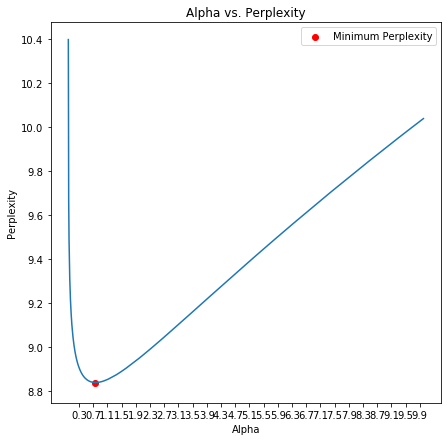

In [137]:
'''
Visualization of how perplexity varies with different values of alpha
'''
min_perplexity_at = np.argmin(perplexity)

min_x = alphas[min_perplexity_at]
min_y = perplexity[min_perplexity_at]

print('Minimum Perplexity : ', min_y)
print('Value of Alpha : ', min_x)

plt.figure(figsize=(7, 7))
plt.plot(alphas.tolist(), perplexity)
plt.scatter(min_x, min_y, c ='r', label = 'Minimum Perplexity')
plt.legend()
plt.xticks(np.arange(0.1, 10, step = 0.4) + .2)
plt.title('Alpha vs. Perplexity')
plt.xlabel('Alpha')
plt.ylabel('Perplexity')
plt.show()

In [3]:
# Question 4 d.
def generate_summaries(file_name):
    '''
    Creates basic summary statistics for words and sentences in the 300-character sequences generated 
    by -
    1. The English model trained by us
    2. model-br.en 
    in 'Question 4c.' above
    '''
    file = open(file_name, mode = 'r')
    generated_sequence = file.read()
    file.close()

    words = generated_sequence.replace('.', '').split()

    unique_words = len(set(words))
    word_counts = len(words)
    mean_word_length = np.mean([len(word) for word in words])
    
    sentences = generated_sequence.replace('\n', '').split('.')
    sentence_counts = len(sentences)
    mean_sentence_length = np.mean([len(sentence.split()) for sentence in sentences])
    
    return ([unique_words, word_counts, mean_word_length], [sentence_counts, mean_sentence_length])

In [9]:
# Question 4 d.
summaries = generate_summaries(data_directory + '/' + 'en_trained_trigram_model_generated_sequence')

word_summary_en_model = summaries[0]
sentence_summary_en_model = summaries[1]

summaries = generate_summaries(data_directory + '/' + 'model-br.en_generated_sequence')

word_summary_model_br_en = summaries[0]
sentence_summary_model_br_en = summaries[1]

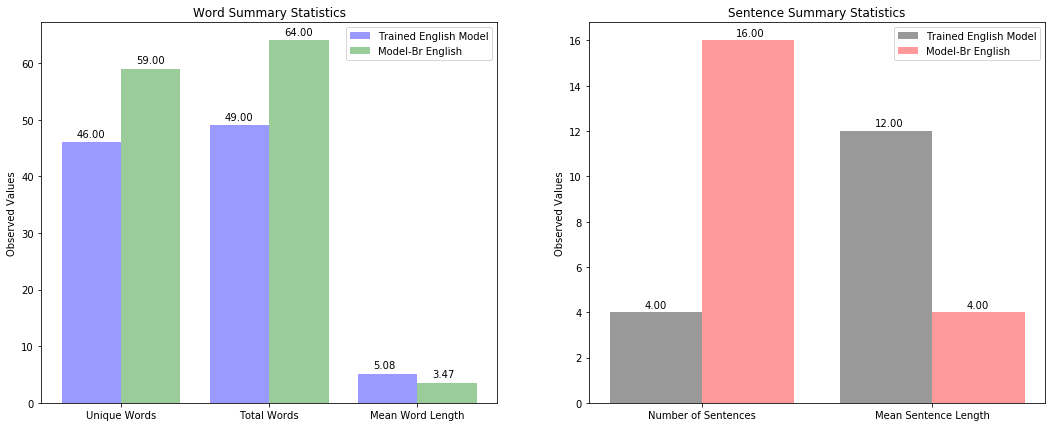

In [10]:
# Question 4 d.
'''
Plot the summaries to visualize how the two models differ 
'''
fig = plt.figure(figsize = (18, 7))

index = np.arange(3)
width = 0.4

ax1 = fig.add_subplot(121)
en_model = ax1.bar(index, word_summary_en_model, width = 0.4, color='blue', alpha = 0.4, label = "Trained English Model")
model_br_en = ax1.bar(index + width, word_summary_model_br_en, width = 0.4, color='green', alpha = 0.4, label = "Model-Br English")

plt.legend(loc = 'upper right')
ax1.set_xticks(index + width / 2)
ax1.set_xticklabels(('Unique Words', 'Total Words', 'Mean Word Length'))
ax1.set_ylabel('Observed Values')
ax1.set_title('Word Summary Statistics')
xlocs, xlabs = plt.xticks()

for x, y in enumerate(word_summary_en_model):
    plt.text(xlocs[x] - 0.3, y + 1, "{:.2f}".format(y))
    
for x, y in enumerate(word_summary_model_br_en):
    plt.text(xlocs[x] + 0.1, y + 1, "{:.2f}".format(y))

index = np.arange(2)
ax2 = fig.add_subplot(122)
en_model = ax2.bar(index, sentence_summary_en_model, width = 0.4, color='black', alpha = 0.4, label = "Trained English Model")
model_br_en = ax2.bar(index + width, sentence_summary_model_br_en, width = 0.4, color='red', alpha = 0.4, label = "Model-Br English")

plt.legend(loc = 'upper right')
ax2.set_xticks(index + width / 2)
ax2.set_xticklabels(('Number of Sentences', 'Mean Sentence Length'))
ax2.set_ylabel('Observed Values')
ax2.set_title('Sentence Summary Statistics')
xlocs, xlabs = plt.xticks()

for x, y in enumerate(sentence_summary_en_model):
    plt.text(xlocs[x] - 0.25, y + 0.2, "{:.2f}".format(y))
    
for x, y in enumerate(sentence_summary_model_br_en):
    plt.text(xlocs[x] + 0.15, y + 0.2, "{:.2f}".format(y))

plt.show()

In [112]:
# Question 3 c.
all_words_in_file = []
words_containing_ng = dict()

with open(training_files[1]) as file:
    for line in file:
        all_words_in_file.append(re.split(r'(\s+)', line))
file.close()

flattened_list = list(itertools.chain.from_iterable(all_words_in_file))
words_with_spaces = []

for index in range(len(flattened_list) - 1):
    if flattened_list[index + 1] != '\n':
        words_with_spaces.append(flattened_list[index] + flattened_list[index + 1])

for word in words_with_spaces:
    if (('ng ' in word) or ('ng.' in word)):
        if word not in words_containing_ng:
            words_containing_ng[word] = 0
        words_containing_ng[word] += 1
    elif (re.search(r'[^\s]ng[^\s.]', word)):
        if word.strip() not in words_containing_ng:
            words_containing_ng[word.strip()] = 0
        words_containing_ng[word.strip()] += 0.5

words_containing_ng = {key : math.ceil(value) for (key, value) in words_containing_ng.items()}  

In [116]:
# Question 3 c.
df = pd.DataFrame(words_containing_ng, index = ['Frequency'])
df.T.sort_values(by = 'Frequency', ascending = False).to_csv(data_directory + '/' + 'training_en_words_with_ng.csv', index=True)

In [28]:
# Question 5 d.
'''
Generate a sequence of 500 characters of test data using the 2 language models specified below
The write_generated_sequence_to_file from above was used to generate the files
'''
# # For the English model trained by us
language_model = data_directory + '/' + 'en_trained_trigram_model'
generated_sequence = generate_from_LM(language_model, 500)
write_generated_sequence_to_file(generated_sequence, language_model)

# For the pre-trained English model model-br.en
language_model = data_directory + '/' + 'model-br.en'
generated_sequence = generate_from_LM(language_model, 500)
write_generated_sequence_to_file(generated_sequence, language_model)

In [31]:
# Question 5 e.
'''
Evaluate the perplexity of the 4 language models given below
'''
language_model = data_directory + '/' + 'en_trained_trigram_model'

test_data = data_directory + '/' + 'en_trained_trigram_model_generated_sequence_test_document'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the trained English model on the test data generated from this model : ', "{:.2f}".format(perplexity))

test_data = data_directory + '/' + 'model-br.en_generated_sequence_test_document'
perplexity = compute_perplexity(language_model, test_data)
print('Perplexity of the trained English model on the test data generated from the pre-trained model-br.en model : ', "{:.2f}".format(perplexity))

Perplexity of the trained English model on the test data generated from this model :  7.37
Perplexity of the trained English model on the test data generated from the pre-trained model-br.en model :  11.04
